In [30]:
from botorch.test_functions.synthetic import Branin
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from omegaconf import OmegaConf

from data.synthetic.synthetic import *
from data.synthetic.synthetic_functions import *
from gp.dsoft_ki.train import train_gp
import gp.soft_gp.train as softki_train
from gp.util import flatten_dataset, split_dataset

# Branin

[(-5.0, 10.0), (0.0, 15.0)]


/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


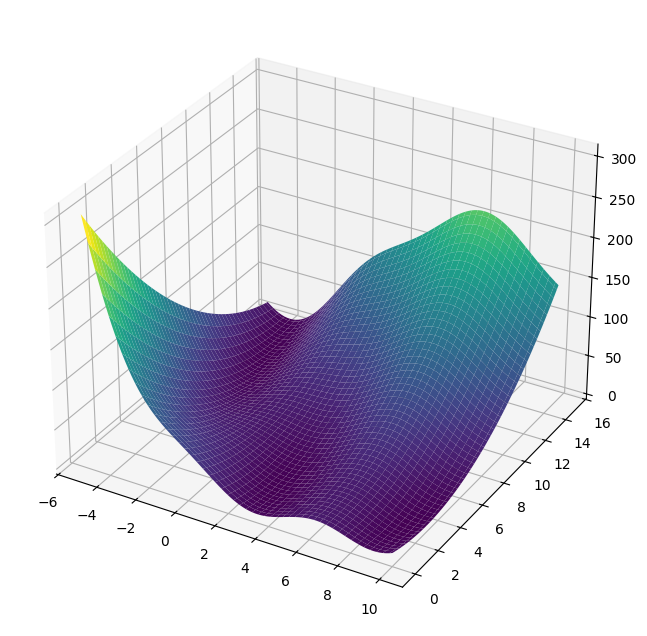

In [2]:
branin = Branin()
print(branin._bounds)
x = torch.linspace(-5, 10, 100)
y = torch.linspace(0, 15, 100)
X, Y = torch.meshgrid(x, y)
points = torch.stack([X.flatten(), Y.flatten()], dim=-1)
Z = branin(points).view(100, 100).cpu().detach().numpy()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none')

# Normalized Branin

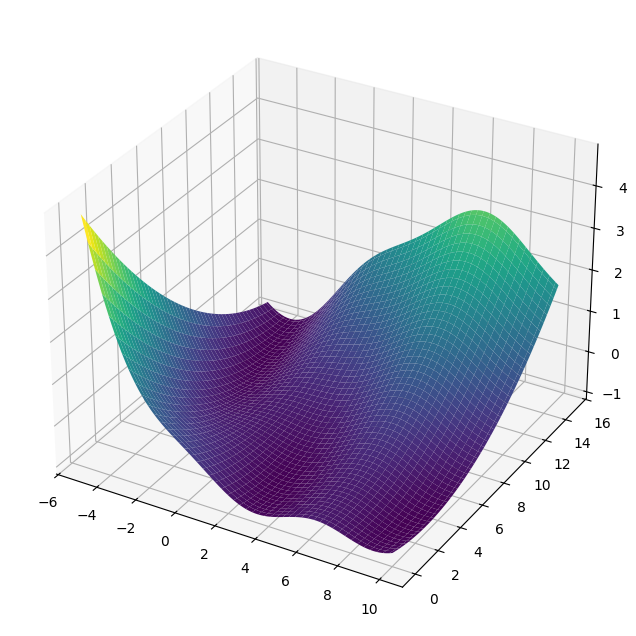

In [3]:
Z = branin(points).view(100, 100).cpu().detach().numpy()
normalize(Z, derivative=False)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none')

# Dataset

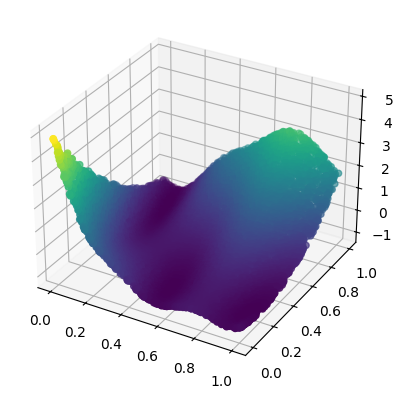

In [4]:
dataset = BraninDataset(10000)
xs = np.array([x for x, y in dataset])
ys = np.array([y['energy'].item() for x , y in dataset])

x1 = np.array([x[0] for x in xs])
x2 = np.array([x[1] for x in xs])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, ys, c=ys, cmap='viridis')

# Normalized Branin with Rescaled Dataset

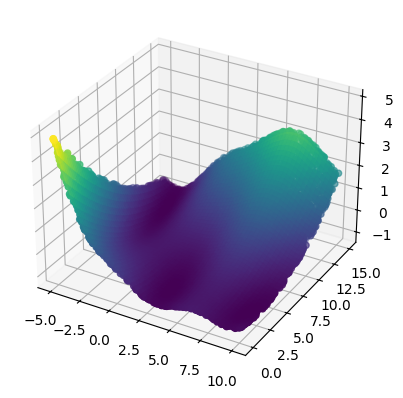

In [5]:
dataset = BraninDataset(10000)
xs = np.array([x for x, y in dataset])
ys = np.array([y['energy'].item() for x , y in dataset])

lb = np.array([item[0] for item in branin._bounds])
ub = np.array([item[1] for item in branin._bounds])
scaled_xs = from_unit_cube(xs, lb, ub)
x1 = np.array([x[0] for x in scaled_xs])
x2 = np.array([x[1] for x in scaled_xs])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = branin(points).view(100, 100).cpu().detach().numpy()
normalize(Z, derivative=False)
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.5)
ax.scatter(x1, x2, ys, c=ys, cmap='viridis')

In [12]:
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=0.9,
    val_frac=0.0
)

CONFIG = OmegaConf.create({
    'model': {
        'name': 'soft-gp',
        'kernel': {
            '_target_': 'RBFKernel'
        },
        'use_scale': False,
        'num_inducing': 512,
        'induce_init': 'kmeans',
        'noise': 1e-3,
        'deriv_noise': 1e-3,
        'learn_noise': False,
        'solver': 'solve',
        'cg_tolerance': 1e-5,
        'mll_approx': 'hutchinson',
        'fit_chunk_size': 1024,
        'use_qr': False,
        'dtype': 'float32',
        'device': 'cuda:0',
    },
    'dataset': {
        'name': 'Sine',
        'num_workers': 1,
        'train_frac': 0.9,
        'val_frac': 0.0,
    },
    'synthetic': {
        'N': 3,
    },
    'training': {
        'seed': 42,
        'batch_size': 256,
        'learning_rate': 1e-2,
        'epochs': 50,
    },
    'wandb': {
        'watch': False,
        'group': 'test',
        'entity': 'bogp',
        'project': 'dsoft-ki',
    }
})

"""
w(x1, z1)  w(x1, z2)  w(x1, z3)
w(x2, z1)  w(x2, z2)  w(x2, z3)
dw/1(x1, z1)  dw/1(x1, z2)  dw/1(x1, z3)
dw/2(x1, z1)  dw/2(x1, z2)  dw/2(x1, z3)
dw/1(x2, z1)  dw/1(x2, z2)  dw/1(x2, z3)
dw/2(x2, z1)  dw/2(x2, z2)  dw/2(x2, z3)
"""

"""
torch.Size([4, 3, 2])
B x M x D -> B x D x M
"""


dsoftki_gp = train_gp(CONFIG, train_dataset, test_dataset)


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 60.08it/s]


FLATTEND torch.Size([9000, 2]) torch.Size([9000, 3])
FEATURES MIN tensor(2.2054e-06) MAX tensor(1.0000)
LABELS MIN tensor(-1.0397) MAX tensor(4.8538) MEAN tensor(-0.0069) STD tensor(0.9962)
DERIVS MIN tensor(-31.2925) MAX tensor(10.1168) STD tensor(5.3690)
Using kmeans ...


Optimizing MLL:   0%|          | 0/50 [00:00<?, ?it/s]/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
Epoch 1/50:   0%|          | 0/50 [00:07<?, ?it/s, MLL=6164.73193359375] 

USING cpu


FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.3492, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.6161, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0694, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1737, device='cuda:0', grad_fn=<StdBackward0>)


1it [00:00,  2.68it/s]
Epoch 1/50:   2%|▏         | 1/50 [00:08<07:15,  8.88s/it, MLL=6164.73193359375]

RMSE: 0.35199207067489624 D_RMSE 3.371168613433838 NEG_MLL -2193.581787109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[2.6602]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 2/50:   2%|▏         | 1/50 [00:16<07:15,  8.88s/it, MLL=3953.37255859375]  

USING cpu


1it [00:00,  3.31it/s]
Epoch 2/50:   4%|▍         | 2/50 [00:17<06:49,  8.53s/it, MLL=3953.37255859375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.2173, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.6307, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0563, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1142, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.2505282461643219 D_RMSE 2.48994779586792 NEG_MLL -1247.57666015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[2.3570]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 3/50:   4%|▍         | 2/50 [00:23<06:49,  8.53s/it, MLL=2841.72265625]     

USING cpu


1it [00:00,  3.27it/s]
Epoch 3/50:   6%|▌         | 3/50 [00:24<06:19,  8.08s/it, MLL=2841.72265625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1591, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.5258, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0586, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1008, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.2152196168899536 D_RMSE 2.205071449279785 NEG_MLL -957.0494995117188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[2.0976]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 4/50:   6%|▌         | 3/50 [00:31<06:19,  8.08s/it, MLL=2384.970947265625] 

USING cpu


1it [00:00,  3.27it/s]
Epoch 4/50:   8%|▊         | 4/50 [00:32<06:12,  8.10s/it, MLL=2384.970947265625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1655, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.4797, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0572, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1008, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.19772757589817047 D_RMSE 2.0859010219573975 NEG_MLL -830.7538452148438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8804]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 5/50:   8%|▊         | 4/50 [00:39<06:12,  8.10s/it, MLL=2195.0419921875]   

USING cpu


1it [00:00,  3.15it/s]
Epoch 5/50:  10%|█         | 5/50 [00:41<06:06,  8.14s/it, MLL=2195.0419921875]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1630, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.4442, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0592, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1052, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.19299085438251495 D_RMSE 2.0381691455841064 NEG_MLL -769.1179809570312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6976]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 6/50:  10%|█         | 5/50 [00:47<06:06,  8.14s/it, MLL=1896.925048828125]

USING cpu


1it [00:00,  3.57it/s]
Epoch 6/50:  12%|█▏        | 6/50 [00:48<05:53,  8.04s/it, MLL=1896.925048828125]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1595, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.4215, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0605, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1065, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.18049897253513336 D_RMSE 1.9484833478927612 NEG_MLL -694.2340698242188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5441]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 7/50:  12%|█▏        | 6/50 [00:55<05:53,  8.04s/it, MLL=1458.164794921875]

USING cpu


1it [00:00,  3.34it/s]
Epoch 7/50:  14%|█▍        | 7/50 [00:56<05:44,  8.02s/it, MLL=1458.164794921875]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1504, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3604, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0610, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1052, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.1727818101644516 D_RMSE 1.8864160776138306 NEG_MLL -645.9501342773438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4139]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 8/50:  14%|█▍        | 7/50 [01:03<05:44,  8.02s/it, MLL=1350.019287109375]

USING cpu


1it [00:00,  3.41it/s]
Epoch 8/50:  16%|█▌        | 8/50 [01:04<05:35,  7.99s/it, MLL=1350.019287109375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1343, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3492, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0609, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.1026, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.16333243250846863 D_RMSE 1.8464356660842896 NEG_MLL -612.5357055664062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3022]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 9/50:  16%|█▌        | 8/50 [01:11<05:35,  7.99s/it, MLL=1346.7442626953125]

USING cpu


1it [00:00,  2.86it/s]
Epoch 9/50:  18%|█▊        | 9/50 [01:12<05:26,  7.97s/it, MLL=1346.7442626953125]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1363, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3656, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0603, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0989, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.1544899046421051 D_RMSE 1.8041355609893799 NEG_MLL -582.7720947265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2032]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 10/50:  18%|█▊        | 9/50 [01:19<05:26,  7.97s/it, MLL=1023.9258422851562]

USING cpu


1it [00:00,  3.48it/s]
Epoch 10/50:  20%|██        | 10/50 [01:20<05:17,  7.94s/it, MLL=1023.9258422851562]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.1003, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3314, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0929, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.14568382501602173 D_RMSE 1.767344355583191 NEG_MLL -556.0713500976562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1133]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 11/50:  20%|██        | 10/50 [01:27<05:17,  7.94s/it, MLL=971.584228515625]  

USING cpu


1it [00:00,  3.32it/s]
Epoch 11/50:  22%|██▏       | 11/50 [01:28<05:11,  8.00s/it, MLL=971.584228515625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0918, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3471, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0638, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0846, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.1281338930130005 D_RMSE 1.6699473857879639 NEG_MLL -501.5277404785156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.0283]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 12/50:  22%|██▏       | 11/50 [01:35<05:11,  8.00s/it, MLL=902.1974487304688] 

USING cpu


1it [00:00,  3.66it/s]
Epoch 12/50:  24%|██▍       | 12/50 [01:36<04:57,  7.84s/it, MLL=902.1974487304688]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0757, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3431, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0635, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0664, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.11021575331687927 D_RMSE 1.5820322036743164 NEG_MLL -447.01025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9359]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 13/50:  24%|██▍       | 12/50 [01:43<04:57,  7.84s/it, MLL=740.1583862304688] 

USING cpu


1it [00:00,  3.50it/s]
Epoch 13/50:  26%|██▌       | 13/50 [01:44<04:51,  7.89s/it, MLL=740.1583862304688]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0457, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3164, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0545, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.09885483235120773 D_RMSE 1.52143394947052 NEG_MLL -409.3019104003906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.8537]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 14/50:  26%|██▌       | 13/50 [01:51<04:51,  7.89s/it, MLL=667.40625]         

USING cpu


1it [00:00,  3.33it/s]
Epoch 14/50:  28%|██▊       | 14/50 [01:52<04:46,  7.95s/it, MLL=667.40625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0265, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3062, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0655, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0499, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.09222058206796646 D_RMSE 1.4621084928512573 NEG_MLL -376.01434326171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7864]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 15/50:  28%|██▊       | 14/50 [01:58<04:46,  7.95s/it, MLL=701.6388549804688] 

USING cpu


1it [00:00,  3.71it/s]
Epoch 15/50:  30%|███       | 15/50 [02:00<04:35,  7.88s/it, MLL=701.6388549804688]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0437, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2944, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0667, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0469, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.08728897571563721 D_RMSE 1.4053467512130737 NEG_MLL -347.75390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.7304]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 16/50:  30%|███       | 15/50 [02:06<04:35,  7.88s/it, MLL=554.6484375]       

USING cpu


1it [00:00,  3.56it/s]
Epoch 16/50:  32%|███▏      | 16/50 [02:07<04:28,  7.91s/it, MLL=554.6484375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0519, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3061, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0662, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0440, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.08451082557439804 D_RMSE 1.3744393587112427 NEG_MLL -331.35321044921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6809]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 17/50:  32%|███▏      | 16/50 [02:14<04:28,  7.91s/it, MLL=531.9747314453125] 

USING cpu


1it [00:00,  3.28it/s]
Epoch 17/50:  34%|███▍      | 17/50 [02:15<04:21,  7.91s/it, MLL=531.9747314453125]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0563, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.3019, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0663, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0439, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.0835953801870346 D_RMSE 1.3480160236358643 NEG_MLL -319.9291076660156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6391]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 18/50:  34%|███▍      | 17/50 [02:23<04:21,  7.91s/it, MLL=565.1470336914062] 

USING cpu


1it [00:00,  3.55it/s]
Epoch 18/50:  36%|███▌      | 18/50 [02:24<04:17,  8.05s/it, MLL=565.1470336914062]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0585, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2904, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0425, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.08260445296764374 D_RMSE 1.328048825263977 NEG_MLL -309.0915222167969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6033]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 19/50:  36%|███▌      | 18/50 [02:30<04:17,  8.05s/it, MLL=539.980712890625]  

USING cpu


1it [00:00,  3.47it/s]
Epoch 19/50:  38%|███▊      | 19/50 [02:32<04:07,  7.97s/it, MLL=539.980712890625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0526, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2785, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0648, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0400, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.08078745752573013 D_RMSE 1.3213720321655273 NEG_MLL -304.71673583984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5714]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 20/50:  38%|███▊      | 19/50 [02:38<04:07,  7.97s/it, MLL=530.5634155273438] 

USING cpu


1it [00:00,  3.52it/s]
Epoch 20/50:  40%|████      | 20/50 [02:40<03:59,  7.97s/it, MLL=530.5634155273438]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0578, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2770, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0655, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0402, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.0806247815489769 D_RMSE 1.314339280128479 NEG_MLL -300.61688232421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5428]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 21/50:  40%|████      | 20/50 [02:47<03:59,  7.97s/it, MLL=468.45196533203125]

USING cpu


1it [00:00,  3.33it/s]
Epoch 21/50:  42%|████▏     | 21/50 [02:48<03:52,  8.01s/it, MLL=468.45196533203125]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0622, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2614, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0656, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0394, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.08045893162488937 D_RMSE 1.2943954467773438 NEG_MLL -291.7419128417969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5173]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 22/50:  42%|████▏     | 21/50 [02:54<03:52,  8.01s/it, MLL=542.21630859375]   

USING cpu


1it [00:00,  3.55it/s]
Epoch 22/50:  44%|████▍     | 22/50 [02:56<03:43,  7.98s/it, MLL=542.21630859375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0557, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2837, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0647, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0395, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07937173545360565 D_RMSE 1.2804844379425049 NEG_MLL -287.0614318847656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4942]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 23/50:  44%|████▍     | 22/50 [03:02<03:43,  7.98s/it, MLL=550.925537109375]  

USING cpu


1it [00:00,  3.25it/s]
Epoch 23/50:  46%|████▌     | 23/50 [03:03<03:34,  7.94s/it, MLL=550.925537109375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0621, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2675, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0648, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0373, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.08003345876932144 D_RMSE 1.2750604152679443 NEG_MLL -283.76434326171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4726]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 24/50:  46%|████▌     | 23/50 [03:10<03:34,  7.94s/it, MLL=464.6722106933594] 

USING cpu


1it [00:00,  3.55it/s]
Epoch 24/50:  48%|████▊     | 24/50 [03:11<03:25,  7.91s/it, MLL=464.6722106933594]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0553, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2859, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0651, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0381, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07948970049619675 D_RMSE 1.2574509382247925 NEG_MLL -277.37823486328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4525]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 25/50:  48%|████▊     | 24/50 [03:18<03:25,  7.91s/it, MLL=476.21649169921875]

USING cpu


1it [00:00,  3.46it/s]
Epoch 25/50:  50%|█████     | 25/50 [03:19<03:17,  7.92s/it, MLL=476.21649169921875]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0562, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2503, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0652, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0378, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07895219326019287 D_RMSE 1.2476955652236938 NEG_MLL -272.5461120605469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4337]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 26/50:  50%|█████     | 25/50 [03:26<03:17,  7.92s/it, MLL=529.1705322265625] 

USING cpu


1it [00:00,  3.47it/s]
Epoch 26/50:  52%|█████▏    | 26/50 [03:27<03:10,  7.94s/it, MLL=529.1705322265625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0605, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2642, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0654, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0381, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07857364416122437 D_RMSE 1.2259149551391602 NEG_MLL -263.9422607421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4153]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 27/50:  52%|█████▏    | 26/50 [03:34<03:10,  7.94s/it, MLL=548.3294677734375] 

USING cpu


1it [00:00,  3.14it/s]
Epoch 27/50:  54%|█████▍    | 27/50 [03:35<03:03,  7.99s/it, MLL=548.3294677734375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0660, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2520, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0651, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0378, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07705453783273697 D_RMSE 1.1974947452545166 NEG_MLL -253.337158203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3971]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 28/50:  54%|█████▍    | 27/50 [03:42<03:03,  7.99s/it, MLL=513.9959716796875] 

USING cpu


1it [00:00,  3.27it/s]
Epoch 28/50:  56%|█████▌    | 28/50 [03:43<02:55,  7.98s/it, MLL=513.9959716796875]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0594, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2604, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0406, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07840758562088013 D_RMSE 1.1097067594528198 NEG_MLL -224.96449279785156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3766]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 29/50:  56%|█████▌    | 28/50 [03:50<02:55,  7.98s/it, MLL=448.4391174316406] 

USING cpu


1it [00:00,  3.33it/s]
Epoch 29/50:  58%|█████▊    | 29/50 [03:51<02:45,  7.87s/it, MLL=448.4391174316406]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0624, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2831, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0393, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07696867734193802 D_RMSE 1.0668748617172241 NEG_MLL -210.02320861816406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3540]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 30/50:  58%|█████▊    | 29/50 [03:58<02:45,  7.87s/it, MLL=479.4840393066406] 

USING cpu


1it [00:00,  3.24it/s]
Epoch 30/50:  60%|██████    | 30/50 [03:59<02:37,  7.89s/it, MLL=479.4840393066406]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0641, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2827, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0376, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07895413041114807 D_RMSE 1.0565589666366577 NEG_MLL -206.20457458496094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3346]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 31/50:  60%|██████    | 30/50 [04:06<02:37,  7.89s/it, MLL=523.9615478515625] 

USING cpu


1it [00:00,  3.31it/s]
Epoch 31/50:  62%|██████▏   | 31/50 [04:07<02:31,  7.95s/it, MLL=523.9615478515625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0609, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2782, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0366, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.0770953968167305 D_RMSE 1.0517359972000122 NEG_MLL -202.79168701171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3177]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 32/50:  62%|██████▏   | 31/50 [04:14<02:31,  7.95s/it, MLL=453.70050048828125]

USING cpu


1it [00:00,  3.53it/s]
Epoch 32/50:  64%|██████▍   | 32/50 [04:15<02:22,  7.94s/it, MLL=453.70050048828125]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0603, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2743, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0365, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07588579505681992 D_RMSE 1.0245749950408936 NEG_MLL -196.68528747558594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3033]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 33/50:  64%|██████▍   | 32/50 [04:17<02:22,  7.94s/it, MLL=251.9642333984375] /home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
Epoch 33/50:  64%|██████▍   | 32/50 [04:22<02:22,  7.94s/it, MLL=422.2920227050781] 

USING cpu


1it [00:00,  3.56it/s]
Epoch 33/50:  66%|██████▌   | 33/50 [04:23<02:14,  7.92s/it, MLL=422.2920227050781]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0577, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2747, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0363, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07544883340597153 D_RMSE 1.0189608335494995 NEG_MLL -192.5935821533203 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2904]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 34/50:  66%|██████▌   | 33/50 [04:30<02:14,  7.92s/it, MLL=518.5880126953125] 

USING cpu


1it [00:00,  3.54it/s]
Epoch 34/50:  68%|██████▊   | 34/50 [04:31<02:07,  7.99s/it, MLL=518.5880126953125]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0700, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2587, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0360, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.0762530192732811 D_RMSE 1.019675374031067 NEG_MLL -192.67214965820312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2785]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 35/50:  68%|██████▊   | 34/50 [04:38<02:07,  7.99s/it, MLL=517.168212890625]  

USING cpu


1it [00:00,  3.63it/s]
Epoch 35/50:  70%|███████   | 35/50 [04:39<01:59,  7.96s/it, MLL=517.168212890625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0620, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2652, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0657, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0362, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07626356929540634 D_RMSE 1.0110048055648804 NEG_MLL -189.0450439453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2670]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 36/50:  70%|███████   | 35/50 [04:45<01:59,  7.96s/it, MLL=471.13226318359375]

USING cpu


1it [00:00,  3.43it/s]
Epoch 36/50:  72%|███████▏  | 36/50 [04:46<01:50,  7.89s/it, MLL=471.13226318359375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0602, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2624, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0360, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07554206252098083 D_RMSE 1.0016289949417114 NEG_MLL -184.53053283691406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2567]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 37/50:  72%|███████▏  | 36/50 [04:53<01:50,  7.89s/it, MLL=504.8110656738281] 

USING cpu


1it [00:00,  3.34it/s]
Epoch 37/50:  74%|███████▍  | 37/50 [04:54<01:42,  7.89s/it, MLL=504.8110656738281]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0564, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2530, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0657, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0356, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07466760277748108 D_RMSE 0.9938344955444336 NEG_MLL -183.2762451171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2475]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 38/50:  74%|███████▍  | 37/50 [05:01<01:42,  7.89s/it, MLL=468.6047668457031] 

USING cpu


1it [00:00,  3.35it/s]
Epoch 38/50:  76%|███████▌  | 38/50 [05:02<01:35,  7.94s/it, MLL=468.6047668457031]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0655, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2509, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0364, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07264915108680725 D_RMSE 0.9800503253936768 NEG_MLL -180.5437469482422 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2381]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 39/50:  76%|███████▌  | 38/50 [05:09<01:35,  7.94s/it, MLL=490.01385498046875]

USING cpu


1it [00:00,  3.28it/s]
Epoch 39/50:  78%|███████▊  | 39/50 [05:10<01:25,  7.81s/it, MLL=490.01385498046875]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0835, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2523, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0375, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.07329541444778442 D_RMSE 0.9671034216880798 NEG_MLL -175.674560546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2271]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 40/50:  78%|███████▊  | 39/50 [05:16<01:25,  7.81s/it, MLL=488.3145446777344] 

USING cpu


1it [00:00,  3.66it/s]
Epoch 40/50:  80%|████████  | 40/50 [05:17<01:17,  7.70s/it, MLL=488.3145446777344]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0827, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2490, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0395, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.06647427380084991 D_RMSE 0.9253803491592407 NEG_MLL -164.71389770507812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2122]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 41/50:  80%|████████  | 40/50 [05:24<01:17,  7.70s/it, MLL=534.4274291992188] 

USING cpu


1it [00:00,  3.15it/s]
Epoch 41/50:  82%|████████▏ | 41/50 [05:25<01:09,  7.76s/it, MLL=534.4274291992188]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0548, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2507, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0639, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0440, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.04713096469640732 D_RMSE 0.7272289395332336 NEG_MLL -119.96080017089844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1861]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 42/50:  82%|████████▏ | 41/50 [05:34<01:09,  7.76s/it, MLL=488.1798400878906] 

USING cpu


1it [00:00,  3.74it/s]
Epoch 42/50:  84%|████████▍ | 42/50 [05:36<01:08,  8.53s/it, MLL=488.1798400878906]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0517, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2476, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0635, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0408, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.03354031220078468 D_RMSE 0.5944119095802307 NEG_MLL -89.15670776367188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1577]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 43/50:  84%|████████▍ | 42/50 [05:43<01:08,  8.53s/it, MLL=462.99456787109375]

USING cpu


1it [00:00,  3.19it/s]
Epoch 43/50:  86%|████████▌ | 43/50 [05:44<00:59,  8.54s/it, MLL=462.99456787109375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0554, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2492, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0628, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0400, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.025258231908082962 D_RMSE 0.5036424994468689 NEG_MLL -70.83650207519531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1382]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 44/50:  86%|████████▌ | 43/50 [05:51<00:59,  8.54s/it, MLL=417.861572265625]  

USING cpu


1it [00:00,  3.02it/s]
Epoch 44/50:  88%|████████▊ | 44/50 [05:52<00:50,  8.38s/it, MLL=417.861572265625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0528, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2482, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0623, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0381, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.021236607804894447 D_RMSE 0.47880223393440247 NEG_MLL -65.89875793457031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1259]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 45/50:  88%|████████▊ | 44/50 [05:58<00:50,  8.38s/it, MLL=395.2734375]       

USING cpu


1it [00:00,  3.38it/s]
Epoch 45/50:  90%|█████████ | 45/50 [06:00<00:40,  8.08s/it, MLL=395.2734375]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0473, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2415, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0367, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.0181239265948534 D_RMSE 0.4366093575954437 NEG_MLL -58.97291946411133 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1179]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 46/50:  90%|█████████ | 45/50 [06:06<00:40,  8.08s/it, MLL=429.6402893066406] 

USING cpu


1it [00:00,  3.45it/s]
Epoch 46/50:  92%|█████████▏| 46/50 [06:07<00:32,  8.03s/it, MLL=429.6402893066406]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0514, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2286, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0370, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.01938396506011486 D_RMSE 0.47026652097702026 NEG_MLL -62.53535461425781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1126]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 47/50:  92%|█████████▏| 46/50 [06:15<00:32,  8.03s/it, MLL=351.6744384765625] 

USING cpu


1it [00:00,  3.19it/s]
Epoch 47/50:  94%|█████████▍| 47/50 [06:16<00:24,  8.11s/it, MLL=351.6744384765625]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0521, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2446, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0623, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0375, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.018651288002729416 D_RMSE 0.44809532165527344 NEG_MLL -60.083740234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1091]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 48/50:  94%|█████████▍| 47/50 [06:18<00:24,  8.11s/it, MLL=118.0938720703125] /home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
Epoch 48/50:  94%|█████████▍| 47/50 [06:22<00:24,  8.11s/it, MLL=432.5931091308594] 

USING cpu


1it [00:00,  3.14it/s]
Epoch 48/50:  96%|█████████▌| 48/50 [06:23<00:15,  7.98s/it, MLL=432.5931091308594]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0436, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2496, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0623, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0367, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.01721506007015705 D_RMSE 0.4325871169567108 NEG_MLL -59.276466369628906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1067]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 49/50:  96%|█████████▌| 48/50 [06:30<00:15,  7.98s/it, MLL=414.8927917480469] 

USING cpu


1it [00:00,  3.25it/s]
Epoch 49/50:  98%|█████████▊| 49/50 [06:31<00:07,  7.84s/it, MLL=414.8927917480469]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0414, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2526, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0621, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0354, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.014749265275895596 D_RMSE 0.4140201210975647 NEG_MLL -57.335968017578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1048]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


Epoch 50/50:  98%|█████████▊| 49/50 [06:38<00:07,  7.84s/it, MLL=382.225341796875]  

USING cpu


1it [00:00,  3.16it/s]
Epoch 50/50: 100%|██████████| 50/50 [06:39<00:00,  7.99s/it, MLL=382.225341796875]

FEATURES MIN tensor(0.0002, device='cuda:0') MAX tensor(0.9998, device='cuda:0')
LABELS MIN tensor(-1.0384, device='cuda:0') MAX tensor(4.2578, device='cuda:0') MEAN tensor(0.0620, device='cuda:0') STD tensor(1.0322, device='cuda:0')
DERIVS MIN tensor(-29.4751, device='cuda:0') MAX tensor(9.9147, device='cuda:0') STD tensor(5.4728, device='cuda:0')
PRED LABELS SHAPE torch.Size([1000]) torch.Size([1000, 2]) MIN tensor(-1.0435, device='cuda:0', grad_fn=<MinBackward1>) MAX tensor(4.2418, device='cuda:0', grad_fn=<MaxBackward1>) MEAN tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward0>) STD tensor(1.0356, device='cuda:0', grad_fn=<StdBackward0>)
RMSE: 0.015241852030158043 D_RMSE 0.420942097902298 NEG_MLL -56.91615676879883 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1035]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0


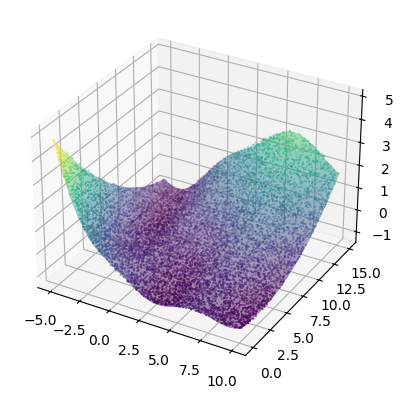

In [29]:
device = "cuda:0"
xs = torch.stack([x for x, y in dataset])
pred_ys = dsoftki_gp.pred(xs.to(device))[:len(xs)].detach().cpu().numpy()

lb = np.array([item[0] for item in branin._bounds])
ub = np.array([item[1] for item in branin._bounds])
scaled_xs = from_unit_cube(xs, lb, ub)
x1 = np.array([x[0] for x in scaled_xs])
x2 = np.array([x[1] for x in scaled_xs])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = branin(points).view(100, 100).cpu().detach().numpy()
normalize(Z, derivative=False)
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.5)
ax.scatter(x1, x2, pred_ys, c=pred_ys, cmap='viridis', s=0.1)

# Soft GP

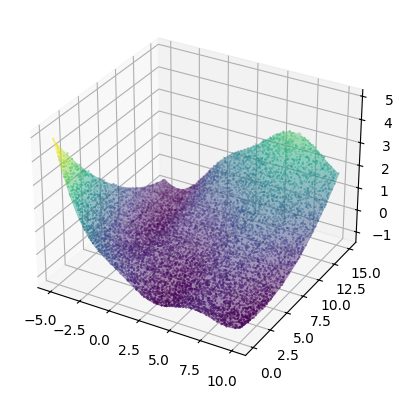

In [32]:
dataset = BraninDataset(10000, with_deriv=False)
xs = np.array([x for x, y in dataset])
ys = np.array([y for x , y in dataset])

lb = np.array([item[0] for item in branin._bounds])
ub = np.array([item[1] for item in branin._bounds])
scaled_xs = from_unit_cube(xs, lb, ub)
x1 = np.array([x[0] for x in scaled_xs])
x2 = np.array([x[1] for x in scaled_xs])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = branin(points).view(100, 100).cpu().detach().numpy()
normalize(Z, derivative=False)
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.5)
ax.scatter(x1, x2, ys, c=ys, cmap='viridis', s=0.1)

# SoftKI

In [37]:
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=0.9,
    val_frac=0.0
)

CONFIG = OmegaConf.create({
    'model': {
        'name': 'soft-gp',
        'kernel': {
            '_target_': 'RBFKernel'
        },
        'T': 0.005,
        'use_T': False,
        'learn_T': False,
        'use_scale': False,
        'threshold': 0.005,
        'learn_threshold': False,
        'use_threshold': False,
        'num_inducing': 512,
        'induce_init': 'kmeans',
        'noise': 1e-3,
        'learn_noise': False,
        'solver': 'solve',
        'cg_tolerance': 1e-5,
        'mll_approx': 'hutchinson',
        'fit_chunk_size': 64,
        'use_qr': False,
        'dtype': 'float32',
        'device': 'cuda:0',
    },
    'dataset': {
        'name': 'Sine',
        'num_workers': 1,
        'train_frac': 0.9,
        'val_frac': 0.0,
    },
    'synthetic': {
        'N': 10000,
    },
    'training': {
        'seed': 42,
        'batch_size': 256,
        'learning_rate': 0.01,
        'epochs': 50,
    },
    'wandb': {
        'watch': False,
        'group': 'test',
        'entity': 'bogp',
        'project': 'dsoft-ki',
    }
})

softki_gp = softki_train.train_gp(CONFIG, train_dataset, test_dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 21.52it/s]


Using kmeans ...
Using softmax_interp


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s, MLL=129.49610900878906]/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/dsoftki/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to t

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 1/50:   2%|▏         | 1/50 [00:00<00:42,  1.14it/s, MLL=129.49610900878906]

RMSE: 0.9458042979240417 NEG_MLL -22.762319564819336 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5578]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 2/50:   2%|▏         | 1/50 [00:01<00:42,  1.14it/s, MLL=75.99393463134766] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 2/50:   4%|▍         | 2/50 [00:01<00:42,  1.12it/s, MLL=75.99393463134766]

RMSE: 0.5319376587867737 NEG_MLL -17.2719669342041 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4780]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 3/50:   4%|▍         | 2/50 [00:02<00:42,  1.12it/s, MLL=72.23767852783203] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 3/50:   6%|▌         | 3/50 [00:02<00:42,  1.09it/s, MLL=72.23767852783203]

RMSE: 0.17262083292007446 NEG_MLL -15.12536334991455 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4233]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 4/50:   6%|▌         | 3/50 [00:03<00:42,  1.09it/s, MLL=62.6970100402832]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 4/50:   8%|▊         | 4/50 [00:03<00:42,  1.09it/s, MLL=62.6970100402832]

RMSE: 0.1752423197031021 NEG_MLL -14.210624694824219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3822]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 5/50:   8%|▊         | 4/50 [00:04<00:42,  1.09it/s, MLL=57.67013168334961] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 5/50:  10%|█         | 5/50 [00:04<00:40,  1.12it/s, MLL=57.67013168334961]

RMSE: 0.17717814445495605 NEG_MLL -13.113574981689453 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3508]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 6/50:  10%|█         | 5/50 [00:05<00:40,  1.12it/s, MLL=45.032798767089844]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 6/50:  12%|█▏        | 6/50 [00:05<00:39,  1.13it/s, MLL=45.032798767089844]

RMSE: 0.18521510064601898 NEG_MLL -12.31354808807373 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3255]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 7/50:  12%|█▏        | 6/50 [00:05<00:39,  1.13it/s, MLL=61.97858810424805] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 7/50:  14%|█▍        | 7/50 [00:06<00:38,  1.12it/s, MLL=61.97858810424805]

RMSE: 0.17742377519607544 NEG_MLL -12.34686279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3043]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 8/50:  14%|█▍        | 7/50 [00:06<00:38,  1.12it/s, MLL=72.33077239990234] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 8/50:  16%|█▌        | 8/50 [00:07<00:37,  1.12it/s, MLL=72.33077239990234]

RMSE: 0.15242750942707062 NEG_MLL -11.995881080627441 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2870]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 9/50:  16%|█▌        | 8/50 [00:07<00:37,  1.12it/s, MLL=64.10335540771484] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 9/50:  18%|█▊        | 9/50 [00:08<00:36,  1.12it/s, MLL=64.10335540771484]

RMSE: 0.15428127348423004 NEG_MLL -11.669745445251465 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2728]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 10/50:  18%|█▊        | 9/50 [00:08<00:36,  1.12it/s, MLL=70.75575256347656] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 10/50:  20%|██        | 10/50 [00:08<00:35,  1.12it/s, MLL=70.75575256347656]

RMSE: 0.15750853717327118 NEG_MLL -11.548948287963867 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2602]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 11/50:  20%|██        | 10/50 [00:09<00:35,  1.12it/s, MLL=39.07841873168945] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 11/50:  22%|██▏       | 11/50 [00:09<00:35,  1.11it/s, MLL=39.07841873168945]

RMSE: 0.1593213826417923 NEG_MLL -11.12958812713623 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2497]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 12/50:  22%|██▏       | 11/50 [00:10<00:35,  1.11it/s, MLL=58.925045013427734]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 12/50:  24%|██▍       | 12/50 [00:10<00:33,  1.12it/s, MLL=58.925045013427734]

RMSE: 0.16285990178585052 NEG_MLL -10.982991218566895 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2412]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 13/50:  24%|██▍       | 12/50 [00:11<00:33,  1.12it/s, MLL=41.88636016845703] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 13/50:  26%|██▌       | 13/50 [00:11<00:33,  1.10it/s, MLL=41.88636016845703]

RMSE: 0.16467763483524323 NEG_MLL -10.91684627532959 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2335]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 14/50:  26%|██▌       | 13/50 [00:12<00:33,  1.10it/s, MLL=49.096797943115234]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

RMSE:


Epoch 14/50:  28%|██▊       | 14/50 [00:12<00:32,  1.12it/s, MLL=49.096797943115234]

 0.16447003185749054 NEG_MLL -11.210064888000488 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2274]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 15/50:  28%|██▊       | 14/50 [00:13<00:32,  1.12it/s, MLL=77.29142761230469] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 15/50:  30%|███       | 15/50 [00:13<00:31,  1.12it/s, MLL=77.29142761230469]

RMSE: 0.17108209431171417 NEG_MLL -10.817151069641113 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2224]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 16/50:  30%|███       | 15/50 [00:14<00:31,  1.12it/s, MLL=45.456398010253906]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 16/50:  32%|███▏      | 16/50 [00:14<00:30,  1.13it/s, MLL=45.456398010253906]

RMSE: 0.16784855723381042 NEG_MLL -10.942059516906738 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2177]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 17/50:  32%|███▏      | 16/50 [00:14<00:30,  1.13it/s, MLL=73.9053726196289]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 17/50:  34%|███▍      | 17/50 [00:15<00:29,  1.13it/s, MLL=73.9053726196289]

RMSE: 0.17124342918395996 NEG_MLL -11.28662395477295 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2139]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 18/50:  34%|███▍      | 17/50 [00:15<00:29,  1.13it/s, MLL=39.887577056884766]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 18/50:  36%|███▌      | 18/50 [00:16<00:28,  1.14it/s, MLL=39.887577056884766]

RMSE: 0.17625272274017334 NEG_MLL -11.010510444641113 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2110]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 19/50:  36%|███▌      | 18/50 [00:16<00:28,  1.14it/s, MLL=46.28678894042969] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 19/50:  38%|███▊      | 19/50 [00:16<00:27,  1.14it/s, MLL=46.28678894042969]

RMSE: 0.1770099550485611 NEG_MLL -11.010595321655273 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2089]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 20/50:  38%|███▊      | 19/50 [00:17<00:27,  1.14it/s, MLL=70.07003784179688] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 20/50:  40%|████      | 20/50 [00:17<00:26,  1.13it/s, MLL=70.07003784179688]

RMSE: 0.17630012333393097 NEG_MLL -10.804447174072266 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2070]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 21/50:  40%|████      | 20/50 [00:18<00:26,  1.13it/s, MLL=70.69197845458984] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 21/50:  42%|████▏     | 21/50 [00:18<00:25,  1.13it/s, MLL=70.69197845458984]

RMSE: 0.1707635074853897 NEG_MLL -10.994268417358398 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2051]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 22/50:  42%|████▏     | 21/50 [00:19<00:25,  1.13it/s, MLL=56.218196868896484]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 22/50:  44%|████▍     | 22/50 [00:19<00:25,  1.11it/s, MLL=56.218196868896484]

RMSE: 0.17104636132717133 NEG_MLL -11.048514366149902 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2038]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 23/50:  44%|████▍     | 22/50 [00:20<00:25,  1.11it/s, MLL=55.31702423095703] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 23/50:  46%|████▌     | 23/50 [00:20<00:23,  1.13it/s, MLL=55.31702423095703]

RMSE: 0.17207154631614685 NEG_MLL -10.898073196411133 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2026]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 24/50:  46%|████▌     | 23/50 [00:21<00:23,  1.13it/s, MLL=48.79617691040039] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 24/50:  48%|████▊     | 24/50 [00:21<00:23,  1.12it/s, MLL=48.79617691040039]

RMSE: 0.17762795090675354 NEG_MLL -10.709684371948242 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2019]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 25/50:  48%|████▊     | 24/50 [00:21<00:23,  1.12it/s, MLL=45.16141128540039] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 25/50:  50%|█████     | 25/50 [00:22<00:22,  1.12it/s, MLL=45.16141128540039]

RMSE: 0.17780548334121704 NEG_MLL -10.959595680236816 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2009]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 26/50:  50%|█████     | 25/50 [00:22<00:22,  1.12it/s, MLL=46.4235725402832]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 26/50:  52%|█████▏    | 26/50 [00:23<00:21,  1.10it/s, MLL=46.4235725402832]

RMSE: 0.17675799131393433 NEG_MLL -10.910564422607422 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2005]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 27/50:  52%|█████▏    | 26/50 [00:23<00:21,  1.10it/s, MLL=54.9596061706543]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 27/50:  54%|█████▍    | 27/50 [00:24<00:20,  1.12it/s, MLL=54.9596061706543]

RMSE: 0.1775028556585312 NEG_MLL -10.937005996704102 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2007]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 28/50:  54%|█████▍    | 27/50 [00:24<00:20,  1.12it/s, MLL=56.03351974487305] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 28/50:  56%|█████▌    | 28/50 [00:24<00:19,  1.12it/s, MLL=56.03351974487305]

RMSE: 0.17986449599266052 NEG_MLL -10.496891975402832 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2003]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 29/50:  56%|█████▌    | 28/50 [00:25<00:19,  1.12it/s, MLL=31.770370483398438]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 29/50:  58%|█████▊    | 29/50 [00:25<00:18,  1.12it/s, MLL=31.770370483398438]

RMSE: 0.1782132387161255 NEG_MLL -10.643585205078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2001]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 30/50:  58%|█████▊    | 29/50 [00:26<00:18,  1.12it/s, MLL=39.027469635009766]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 30/50:  60%|██████    | 30/50 [00:26<00:17,  1.13it/s, MLL=39.027469635009766]

RMSE: 0.17915157973766327 NEG_MLL -10.871452331542969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1996]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 31/50:  60%|██████    | 30/50 [00:27<00:17,  1.13it/s, MLL=46.86868667602539] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 31/50:  62%|██████▏   | 31/50 [00:27<00:17,  1.12it/s, MLL=46.86868667602539]

RMSE: 0.18108369410037994 NEG_MLL -10.744680404663086 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1999]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 32/50:  62%|██████▏   | 31/50 [00:28<00:17,  1.12it/s, MLL=57.092464447021484]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 32/50:  64%|██████▍   | 32/50 [00:28<00:16,  1.11it/s, MLL=57.092464447021484]

RMSE: 0.17686760425567627 NEG_MLL -10.85185718536377 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1996]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 33/50:  64%|██████▍   | 32/50 [00:29<00:16,  1.11it/s, MLL=46.894287109375]   

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 33/50:  66%|██████▌   | 33/50 [00:29<00:16,  1.06it/s, MLL=46.894287109375]

RMSE: 0.1781238168478012 NEG_MLL -10.908344268798828 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1994]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 34/50:  66%|██████▌   | 33/50 [00:30<00:16,  1.06it/s, MLL=53.767364501953125]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 34/50:  68%|██████▊   | 34/50 [00:30<00:15,  1.03it/s, MLL=53.767364501953125]

RMSE: 0.18064796924591064 NEG_MLL -10.861968040466309 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1993]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 35/50:  68%|██████▊   | 34/50 [00:31<00:15,  1.03it/s, MLL=39.99418258666992] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 35/50:  70%|███████   | 35/50 [00:31<00:14,  1.01it/s, MLL=39.99418258666992]

RMSE: 0.18431654572486877 NEG_MLL -10.696511268615723 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1992]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 36/50:  70%|███████   | 35/50 [00:32<00:14,  1.01it/s, MLL=48.39390182495117] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 36/50:  72%|███████▏  | 36/50 [00:32<00:14,  1.03s/it, MLL=48.39390182495117]

RMSE: 0.18395471572875977 NEG_MLL -10.933050155639648 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1988]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 37/50:  72%|███████▏  | 36/50 [00:33<00:14,  1.03s/it, MLL=30.12265968322754] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 37/50:  74%|███████▍  | 37/50 [00:33<00:13,  1.02s/it, MLL=30.12265968322754]

RMSE: 0.18088364601135254 NEG_MLL -10.788594245910645 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1989]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 38/50:  74%|███████▍  | 37/50 [00:34<00:13,  1.02s/it, MLL=44.68052291870117] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 38/50:  76%|███████▌  | 38/50 [00:34<00:12,  1.02s/it, MLL=44.68052291870117]

RMSE: 0.1849721372127533 NEG_MLL -10.793440818786621 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1989]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 39/50:  76%|███████▌  | 38/50 [00:35<00:12,  1.02s/it, MLL=64.9517593383789]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 39/50:  78%|███████▊  | 39/50 [00:35<00:11,  1.03s/it, MLL=64.9517593383789]

RMSE: 0.1797376126050949 NEG_MLL -10.921586036682129 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1990]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 40/50:  78%|███████▊  | 39/50 [00:36<00:11,  1.03s/it, MLL=75.2078857421875]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 40/50:  80%|████████  | 40/50 [00:36<00:10,  1.01s/it, MLL=75.2078857421875]

RMSE: 0.1767776608467102 NEG_MLL -10.847349166870117 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1982]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 41/50:  80%|████████  | 40/50 [00:37<00:10,  1.01s/it, MLL=45.044029235839844]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 41/50:  82%|████████▏ | 41/50 [00:37<00:08,  1.01it/s, MLL=45.044029235839844]

RMSE: 0.1821904331445694 NEG_MLL -11.235193252563477 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1989]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 42/50:  82%|████████▏ | 41/50 [00:38<00:08,  1.01it/s, MLL=52.12574005126953] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 42/50:  84%|████████▍ | 42/50 [00:38<00:07,  1.06it/s, MLL=52.12574005126953]

RMSE: 0.18389299511909485 NEG_MLL -11.101128578186035 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1998]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 43/50:  84%|████████▍ | 42/50 [00:39<00:07,  1.06it/s, MLL=38.62153244018555] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 43/50:  86%|████████▌ | 43/50 [00:39<00:06,  1.06it/s, MLL=38.62153244018555]

RMSE: 0.18325486779212952 NEG_MLL -10.696022033691406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2001]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 44/50:  86%|████████▌ | 43/50 [00:40<00:06,  1.06it/s, MLL=35.15906524658203] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 44/50:  88%|████████▊ | 44/50 [00:40<00:05,  1.05it/s, MLL=35.15906524658203]

RMSE: 0.17854835093021393 NEG_MLL -11.15035629272461 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1993]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 45/50:  88%|████████▊ | 44/50 [00:41<00:05,  1.05it/s, MLL=64.37974548339844] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 45/50:  90%|█████████ | 45/50 [00:41<00:04,  1.07it/s, MLL=64.37974548339844]

RMSE: 0.1787518560886383 NEG_MLL -10.663640022277832 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2006]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 46/50:  90%|█████████ | 45/50 [00:42<00:04,  1.07it/s, MLL=64.47406005859375] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 46/50:  92%|█████████▏| 46/50 [00:42<00:03,  1.07it/s, MLL=64.47406005859375]

RMSE: 0.17800714075565338 NEG_MLL -11.010313987731934 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2000]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 47/50:  92%|█████████▏| 46/50 [00:43<00:03,  1.07it/s, MLL=42.09381103515625] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 47/50:  94%|█████████▍| 47/50 [00:43<00:02,  1.07it/s, MLL=42.09381103515625]

RMSE: 0.17999394237995148 NEG_MLL -10.790815353393555 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1997]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 48/50:  94%|█████████▍| 47/50 [00:43<00:02,  1.07it/s, MLL=34.851219177246094]

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 48/50:  96%|█████████▌| 48/50 [00:44<00:01,  1.07it/s, MLL=34.851219177246094]

RMSE: 0.17895126342773438 NEG_MLL -10.874796867370605 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1997]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 49/50:  96%|█████████▌| 48/50 [00:44<00:01,  1.07it/s, MLL=40.5903434753418]  

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 49/50:  98%|█████████▊| 49/50 [00:45<00:00,  1.07it/s, MLL=40.5903434753418]

RMSE: 0.1857755184173584 NEG_MLL -10.856162071228027 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.1996]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


Epoch 50/50:  98%|█████████▊| 49/50 [00:45<00:00,  1.07it/s, MLL=46.47574996948242] 

Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-01.


Epoch 50/50: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s, MLL=46.47574996948242]

RMSE: 0.18536946177482605 NEG_MLL -11.02017879486084 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.2006]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE 1.0 THRESHOLD 0.004999999422580004 T 0.005000000819563866


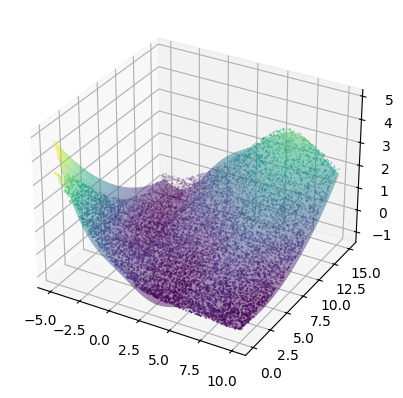

In [38]:
xs = torch.stack([x for x, y in dataset])
pred_ys = softki_gp.pred(xs.to(device))[:len(xs)].detach().cpu().numpy()

lb = np.array([item[0] for item in branin._bounds])
ub = np.array([item[1] for item in branin._bounds])
scaled_xs = from_unit_cube(xs, lb, ub)
x1 = np.array([x[0] for x in scaled_xs])
x2 = np.array([x[1] for x in scaled_xs])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z = branin(points).view(100, 100).cpu().detach().numpy()
normalize(Z, derivative=False)
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor='none', alpha=0.5)
ax.scatter(x1, x2, pred_ys, c=ys, cmap='viridis', s=0.1)